In [1]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from imblearn.over_sampling import SMOTE
import shap

import matplotlib.pyplot as plt

In [2]:
# Load processed data
df = pd.read_csv(r"C:\Users\u1158100\Desktop\GDG_research\delisting_detection_py_project\processed\processed_data.csv")
df.head()

,delist_tab,month_count,_201901,_201902,_201903,_201904,_201905,_201911,_201912,_202007,...,NRDL_0,NRDL_1,NRDL_2,NRDL_LIMTT_0,NRDL_LIMTT_1,ENTRY_TIME_0,ENTRY_TIME_1,ENTRY_TIME_2,ENTRY_TIME_3,ENTRY_TIME_4
0,1,-1.418036,-0.201737,-0.197625,-0.200282,-0.199097,-0.199180,-0.202610,-0.198688,-0.196944,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,-0.048420,-0.201422,-0.194895,-0.198902,-0.198658,-0.198258,-0.201095,-0.197507,-0.196199,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,-1.466951,-0.201755,-0.197625,-0.200282,-0.199097,-0.199180,-0.202610,-0.198688,-0.196944,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1,-1.466951,-0.201755,-0.197625,-0.200282,-0.199097,-0.199180,-0.202610,-0.198688,-0.196944,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,-1.222377,-0.201541,-0.197465,-0.200263,-0.199097,-0.199144,-0.202610,-0.198688,-0.196944,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


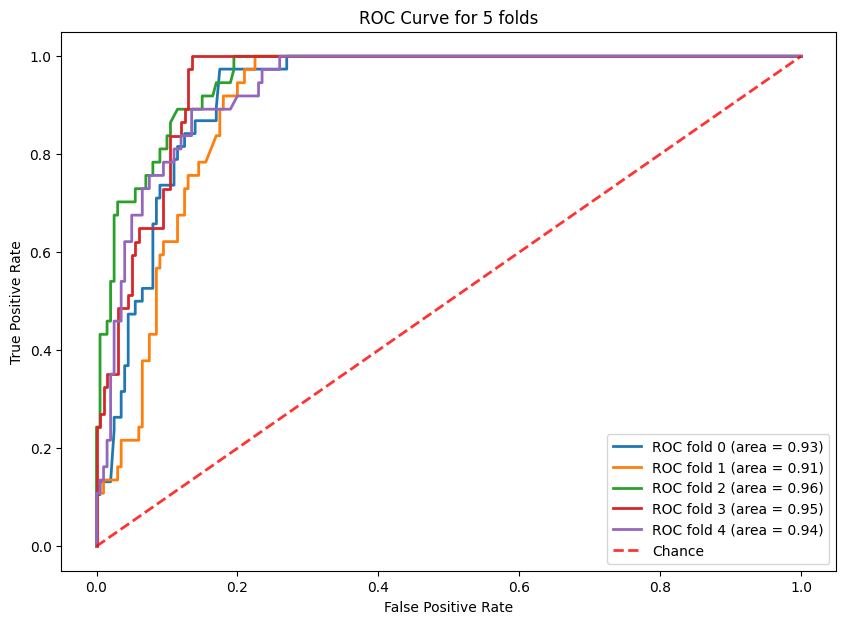

In [3]:
X = df.drop('delist_tab', axis=1)
y = df['delist_tab'] 

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=816) 

precision_list = []
recall_list = []
f1_list = []
tpr_list = []  
fpr_list = []  
roc_auc_list = []
y_real = []
y_proba = [] 

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 

    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train) 

    model = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)
    model.fit(X_train_res, y_train_res) 

    y_pred = model.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1) 

    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    roc_auc_list.append(roc_auc)
    y_real.append(y_test)
    y_proba.append(y_score)
    
plt.figure(figsize=(10, 7))
for i in range(5):
    plt.plot(fpr_list[i], tpr_list[i], lw=2,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc_list[i]))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 5 folds')
plt.legend(loc="lower right")
plt.show()

In [4]:
print("Precision is:\n" + '\n'.join(map(str, precision_list)))
print("recall is:\n" + '\n'.join(map(str, recall_list)))
print("f1 is:\n" + '\n'.join(map(str, f1_list)))

Precision is:
[1.   0.38]
[1.         0.43529412]
[1.         0.43023256]
[1.         0.40659341]
[1.         0.41111111]
recall is:
[0.69 1.  ]
[0.76 1.  ]
[0.755 1.   ]
[0.73 1.  ]
[0.735 1.   ]
f1 is:
[0.81656805 0.55072464]
[0.86363636 0.60655738]
[0.86039886 0.60162602]
[0.84393064 0.578125  ]
[0.84726225 0.58267717]


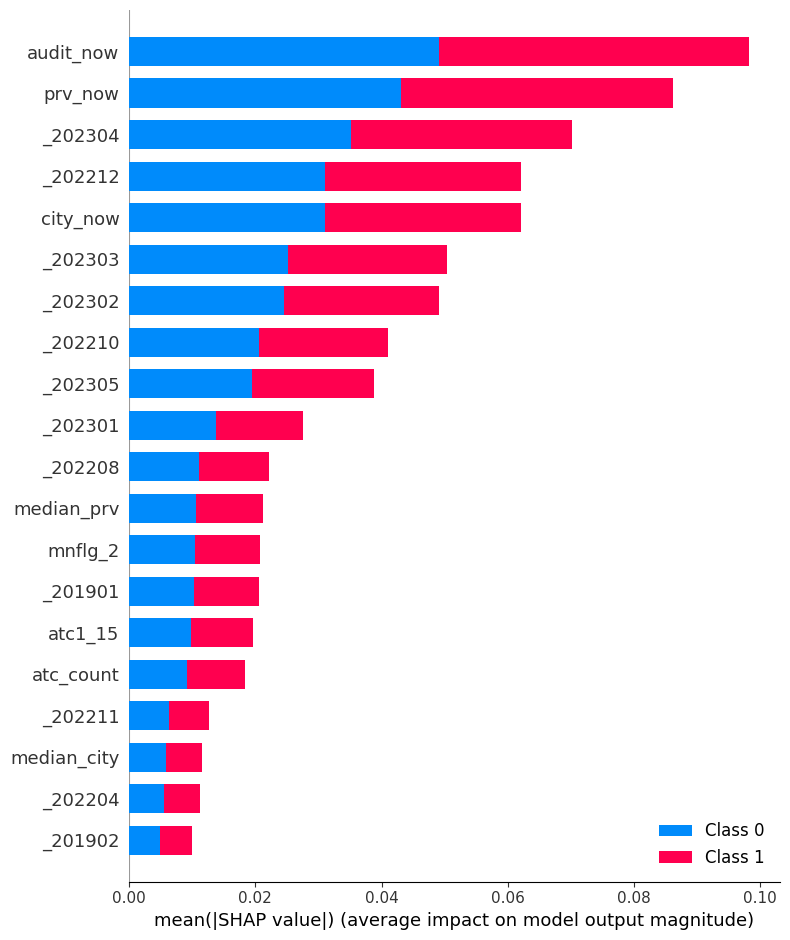

In [5]:
# 6. Feature Importance and SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train_res) 
# Plot SHAP values (for a sample of 100 instances for visualization)
shap.summary_plot(shap_values, X_train_res)